<a href="https://colab.research.google.com/github/KhudV/graduation_paper_code/blob/main/text%20generation/%D0%92%D0%9A%D0%A0_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузка данных

In [ ]:
import pandas as pd 
import numpy as np
from random import sample

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
from IPython.display import clear_output


import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv("netflix_titles.csv")
data[:5]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


## Препроцессинг

In [ ]:
texts = list(data['description'])
texts = [' ' + text for text in texts]
texts[0]

' As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.'

In [ ]:
tokens = list(set(''.join(texts)))

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  127


In [ ]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [ ]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [ ]:
# преобразуем текст в числа для подачи данных в нейронную сеть

def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [ ]:
#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(texts[::2000]))
print(to_matrix(texts[::2000], token_to_id))

 As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.
 Charming comic Michael McIntyre talks family, technology, sharks, accents and the time he confused himself for a world leader in this stand-up special.
 A couple finds unexpected drama when, after 40 years of living in the same Brooklyn walk-up, they attempt to sell their apartment and buy a new one.
 Jeff's straight-and-narrow life changes abruptly when his buddies take him out for a birthday bash – the night before a crucial med school interview.
 Go inside the lives of extraordinary, black female entrepreneurs as they discuss building legacies and pioneering a new future for the next generation.
[[114  26  56 114  62  28   8 114  47  12  35  62  28   8 114  90  28  12
    8  56 114  35  62  28 114  28  90  45 114 117  47 114  62 105  56 114
   71 105  47  28 107 114  47 105  71 100 100  12  42  28   8 114  86 105
    8  56  35  28

## Построение модели

In [ ]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens, maxlensent=21, emb_size=16, rnn_num_units=64, num_layers=2):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hid_state):
        x = self.emb(x)
        if hid_state is not None:
            h_seq, hid_state = self.lstm(x, hid_state)
        else:
            h_seq, hid_state = self.lstm(x)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hid_state

## Обучение модели

In [ ]:
MAX_LENGTH = max(map(len, texts))
MAX_LENGTH

249

In [ ]:
model = CharLSTMLoop(num_tokens=num_tokens, maxlensent=MAX_LENGTH, emb_size=30, rnn_num_units=690, num_layers=2)
opt = torch.optim.Adam(model.parameters())
history = []
print (model) 

CharLSTMLoop(
  (emb): Embedding(127, 30)
  (lstm): LSTM(30, 690, num_layers=2, batch_first=True)
  (hid_to_logits): Linear(in_features=690, out_features=127, bias=True)
)


In [ ]:
# # после 3500 проходов вручную понизили шаг
opt = torch.optim.Adam(model.parameters(), lr=0.001*0.5)
# # после 4100 проходов вручную понизили шаг
opt = torch.optim.Adam(model.parameters(), lr=0.001*0.2)

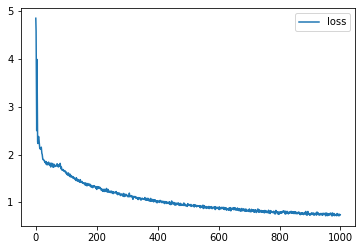

tensor(0.7404, grad_fn=<NegBackward0>)


,loss
count,1000.000000
mean,1.077481
std,0.397219
min,0.716180
25%,0.809957
50%,0.939788
75%,1.213947
max,4.852456


In [ ]:
# до 2000 проходов батч использовался размером 64
# после 2000 проходов батч использовался размером 128
# Всего проходов: 4500


for i in range(1000):
    batch_ix = to_matrix(sample(texts, 64), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq, _ = model(batch_ix, hid_state=None)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.cpu().numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()
        print (loss)

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

hist_df = pd.DataFrame(history,columns=['loss'])
hist_df['loss'] = hist_df['loss'].astype(float)
hist_df.describe()

## Генерация текста

In [ ]:
def generate_sample(model, tokens, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = None
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        _, hid_state = model.forward(x_sequence[:, i].unsqueeze(0), hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logp_next, hid_state = model.forward(x_sequence[:, -1].unsqueeze(0), hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
print(generate_sample(model, tokens))

 A woman longson as his also the desperate biopows of each uncover when he bether after he pinnens is hired a leader of in 2-1138, a young man handsoss her by as accodent.                                                                              
